In [1]:
from nilmtk.dataset import DataSet
from nilmtk.metergroup import MeterGroup
import sys
sys.path.append("../src")
import pandas as pd
from utils.utils import * 
from utils.pre_processing import *
from utils.visual_functions import *
import matplotlib.pyplot as plt
from api import API
%matplotlib inline

/Users/sambaiga/miniconda3/envs/nilmtk-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/sambaiga/miniconda3/envs/nilmtk-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Parameters

In [2]:
experiment_name = 'UK_DALE_TEST'
fig_path = "../figure/publications/"
epochs = 50
denoise = True
sequence_length =99
batch_size = 128
dropout = 0.1
data_path ="../../data/ukdale.h5"
input_processing = True,
processing_type = "quantile_filter"
vis_test_window  = slice("2015-06-19 08:00:00-00:00", "2015-06-20 02:00:00-00:00")
vis_valid_window = slice("2015-04-19 08:00:00-00:00", "2015-04-20 02:00:00-00:00")
!pip install hydra-core --upgrade

Requirement already up-to-date: hydra-core in /Users/sambaiga/miniconda3/envs/nilmtk-env/lib/python3.6/site-packages (0.11.3)


In [3]:
appliance_metadata={
    'on_threshold': 
    {'washer dryer':20, 'dish washer':10, 'television':10, 'kettle':2000, 'microwave':200,'fridge freezer':50},
    'mean': 
    {'washer dryer':400, 'dish washer':700, 'television':10, 'kettle':700, 'microwave':500, 'fridge freezer':200},
    'std': 
    {'washer dryer':400, 'dish washer':700, 'television':30, 'kettle':1000, 'microwave':800, 'fridge freezer':400},
    
    'on_duration': 
    {'washer dryer':120, 'dish washer':120, 'television':50,'fridge freezer':50, 'kettle':10, 'microwave':10},
    'mains': 
    {'mean':522, 'std':814}
    }

appliances_names={'fridge freezer':"FRZ", 'washer dryer':"WD", 'dish washer':"DW", 'television':"TV", 'kettle':"KT", "microwave":"MW"}
optim_params ={"opt_params": {"lr": 1e-3, "betas":(0.99, 0.98), "eps":1e-8},
             "opt_name":"adam",
             "sheduler_name":"ReduceLROnPlateau",
             "softmax":True
            }

experiment = {
  'power': {
    'mains': ['apparent'],
    'appliance': ['active']
  },
  
  'exp_name':experiment_name,
  'sample_rate': 30,
 
   'appliance_meta_data': appliance_metadata,
  'appliances': ['fridge freezer', 'washer dryer', 'dish washer', 'television', 'kettle', 'microwave'],
  'app_names': {'fridge freezer':"FRZ", 'washer dryer':"WD", 'dish washer':"DW", 'television':"TV", 'kettle':"KT", "microwave":"MW"},
  'disaggregate':False,
  'methods': {
        'M-CNN': ""

      
        
   },
     'train': {
      'datasets': {
              'UKDALE': {
                  'path': data_path,
          'buildings': {
            1: [("2015-01-03", "2015-01-31"), ("2015-02-05", "2015-02-28"), ("2015-03-01", "2015-03-31")]
          }
        }
        }
    },
    'valid': {
      'datasets': {
              'UKDALE': {
                  'path': data_path,
          'buildings': {
          1: [("2015-04-01", "2015-04-30"),("2015-05-01", "2015-05-15"), ("2015-06-01", "2015-06-14")]
          }
        }
        }
    },
    'test': {
    'datasets': {
      'UKDALE': {
        'path': data_path,
        'buildings': {
         1: [("2015-06-15", "2015-06-30")]
        }
    }
  },
        'metrics':['mae']
}
}

In [4]:
api_res = API(experiment)

In [5]:
print("............... Loading Validation Data for training ...................")
test_mains, test_submeters, dataset = api_res.load_train_data(api_res.test_datasets_dict)

In [6]:
test_submeters.head()

fridge freezer  washer dryer  dish washer  \
2015-06-15 00:59:30+01:00       -0.271875          -1.0         -1.0   
2015-06-15 01:00:00+01:00       -0.272500          -1.0         -1.0   
2015-06-15 01:00:30+01:00       -0.273750          -1.0         -1.0   
2015-06-15 01:01:00+01:00       -0.273125          -1.0         -1.0   
2015-06-15 01:01:30+01:00       -0.272500          -1.0         -1.0   

                           television  kettle  microwave  FRZ_state  WD_state  \
2015-06-15 00:59:30+01:00        -0.3  -0.699   -0.62375          1         0   
2015-06-15 01:00:00+01:00        -0.3  -0.699   -0.62375          1         0   
2015-06-15 01:00:30+01:00        -0.3  -0.699   -0.62375          1         0   
2015-06-15 01:01:00+01:00        -0.3  -0.699   -0.62375          1         0   
2015-06-15 01:01:30+01:00        -0.3  -0.699   -0.62375          1         0   

                           DW_state  TV_state  KT_state  MW_state  
2015-06-15 00:59:30+01:00         0         0         0         0  
2015-06-15 01:00:00+01:00         0         0         0         0  
2015-06-15 01:00:30+01:00         0         0         0         0  
2015-06-15 01:01:00+01:00         0         0         0         0  
2015-06-15 01:01:30+01:00         0         0         0         0

In [8]:
x = test_mains.drop(columns=["denoise"]).values
y  = test_submeters[['fridge freezer', 'washer dryer', 'dish washer', 'television', 'kettle',
       'microwave']].values
z = test_submeters[['FRZ_state', 'WD_state', 'DW_state', 'TV_state',
       'KT_state', 'MW_state']].values
ts =test_mains.index.values

np.save("ukdale/test/feature.npy", x)
np.save("ukdale/test/power.npy", y)
np.save("ukdale/test/state.npy", z)
np.save("ukdale/test/tsp.npy", z)

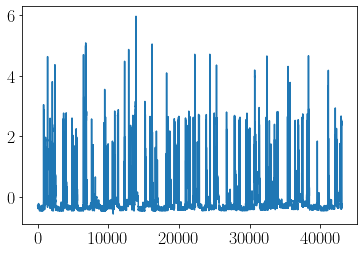

In [16]:
plt.plot(test_mains.drop(columns=["denoise"]).values[:,0])

In [23]:
from utils.data import DataLoader
data = DataLoader(test_mains, test_submeters, appliances_names)

generate context sequences
generate context sequences
generate context sequences
Input data: (43081, 49, 7) targets: (43081, 7)


## Dataloader

In [26]:
print("............... Loading Training Data for training ...................")
train_mains, train_submeters, dataset = api_res.load_train_data(api_res.train_datasets_dict)
print("............... Loading Validation Data for training ...................")
val_mains, val_submeters, dataset = api_res.load_train_data(api_res.valid_datasets_dict)

In [27]:
x = train_mains.drop(columns=["denoise"]).values
y  = train_submeters[['fridge freezer', 'washer dryer', 'dish washer', 'television', 'kettle',
       'microwave', 'FRZ_state']].values
z = train_submeters[['FRZ_state', 'WD_state', 'DW_state', 'TV_state',
       'KT_state', 'MW_state']].values
ts =train_mains.index.values

np.save("ukdale/train/feature.npy", x)
np.save("ukdale/train/power.npy", y)
np.save("ukdale/train/state.npy", z)
np.save("ukdale/train/tsp.npy", z)

In [28]:
x = val_mains.drop(columns=["denoise"]).values
y  = val_submeters[['fridge freezer', 'washer dryer', 'dish washer', 'television', 'kettle',
       'microwave', 'FRZ_state']].values
z = val_submeters[['FRZ_state', 'WD_state', 'DW_state', 'TV_state',
       'KT_state', 'MW_state']].values
ts =val_mains.index.values

np.save("ukdale/val/feature.npy", x)
np.save("ukdale/val/power.npy", y)
np.save("ukdale/val/state.npy", z)
np.save("ukdale/val/tsp.npy", z)

In [ ]:
loader=torch.utils.data.DataLoader(
            data,
            batch_size=128,
            shuffle=True)



In [ ]:
context_x, context_y, context_z, target_x, target_y, target_z=next(iter(loader))

In [ ]:
m = ContextNILM()
m(context_x, context_y, context_z, target_x, target_y, target_z)

In [ ]:
 ### Loss

In [ ]:
#z = z.unsqueeze(1).repeat(1, num_targets, 1)  # [B, T_target, H]
#mu_prior

In [ ]:
dec = Decoder()
dec(out, mu_prior, target_x)

In [17]:
m = torch.randn(4, 20)
x = torch.randn(4).unsqueeze().expand_as(m)

TypeError: unsqueeze() missing 1 required positional arguments: "dim"